In [1]:
import os
import sklearn
import numpy as np
from numpy import unwrap, diff, abs, angle
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle
import scipy
from scipy.signal import butter, filtfilt, hilbert
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense,  BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import mne
from mne.preprocessing import ICA
import pywt
from scipy.stats import skew, kurtosis
from scipy.signal import spectrogram
from mne.viz import plot_topomap
from scipy.signal import welch
import matplotlib.pyplot as plt

Preproccesing Functions

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

def custom_detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    return df_new

def df_to_raw(df, sfreq=250):
    info = mne.create_info(ch_names=list(df.columns), sfreq=sfreq, ch_types=['eeg'] * df.shape[1])
    raw = mne.io.RawArray(df.T.values * 1e-6, info)  # Converting values to Volts from microvolts for MNE
    return raw

def reject_artifacts(df, channel):
    threshold_factor = 5
    median = df[channel].median()
    mad = np.median(np.abs(df[channel] - median))
    spikes = np.abs(df[channel] - median) > threshold_factor * mad
    x = np.arange(len(df[channel]))
    cs = CubicSpline(x[~spikes], df[channel][~spikes]) # Interpolate using Cubic Spline
    interpolated_values = cs(x)
    interpolated_values[spikes] *= 0.1  # Make interpolated values 0.1 times smaller
    spike_values = np.abs(interpolated_values - median) > threshold_factor * mad
    interpolated_values[spike_values] *= 0.001 
    df[channel] = interpolated_values
    return df

def plot_eeg_data(before, after, title, colors):
    """Plots EEG data."""
    plt.figure(figsize=(12, 8))
    for i in range(before.shape[1]):
        plt.plot(before[:, i] + i * 200, color=colors[i])  # Offset added for visualization clarity
    for i in range(after.shape[1]):
        plt.plot(after[:, i] + i * 200, color=colors[i], linestyle='--')
    plt.title(title)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()


Define the dataset

In [3]:
# Creating a new folder for spike rejected data
new_folder = 'spike_rejected_data_OW'
if not os.path.exists(new_folder):
    os.makedirs(new_folder)    
folder_name = 'ES_1'
selected_columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']

In [4]:
folder_name = 'OW_1'
subfolder_name = 'spike_rejected_data_OW'
# Full path to the subfolder
spike_rejected_folder = os.path.join(folder_name, subfolder_name)

In [5]:
spike_rejected_folder

'OW_1\\spike_rejected_data_OW'

In [6]:

duration = 40 
EEG_Before_ICA = []
event = []
totaldata = []
face = []
scene = []
baserejected=[]
if os.path.exists(spike_rejected_folder) and os.path.isdir(spike_rejected_folder):
    print(os.path)
    for file_name in os.listdir(spike_rejected_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(spike_rejected_folder, file_name)
            s_temp = pd.read_csv(file_path, header=0)
            totaldata.append(s_temp)
            instruction = s_temp.iloc[:, 8]

            baseline = s_temp[s_temp.iloc[:, -1].isin(['b', 'g'])].iloc[:, :-1]
            baseline_avg = baseline.mean() if not baseline.empty else 0

            non_baseline_data = s_temp[~s_temp.iloc[:, -1].isin(['b', 'g'])]
            inst_activity=non_baseline_data.iloc[:, 8]
            # print('inst_base_rej', inst_activity)
            adjusted_non_baseline = non_baseline_data.iloc[:, :-1] - baseline_avg
            
            concatenated = pd.concat([baseline, adjusted_non_baseline], ignore_index=True)
            s_temp_baseline_rejected= pd.concat([concatenated, instruction], axis=1) 
         
            activity_baseline_rejected_with_inst= pd.concat([adjusted_non_baseline, inst_activity], axis=1) 

            baserejected.append(activity_baseline_rejected_with_inst)
            # Check if the last column contains 'I' or 'O'
            if 'I' in instruction.values or 'O' in instruction.values:
                scene.append(s_temp_baseline_rejected)
                
            if 'M' in instruction.values or 'F' in instruction.values:
                face.append(s_temp_baseline_rejected)  
                          
            df_temp = s_temp.iloc[:, :8]
            EEG_Before_ICA.append(df_temp)
            event.append(instruction)

<module 'ntpath' (frozen)>


In [7]:
baserejected_np = np.vstack(baserejected)
label_brj = baserejected_np[:, -1:]

labels=[]
for i in range(len(baserejected_np)): #len(pp_sig_event) = the whole sample points, (df_temp.shape[0]*B_N)
    if 'M' in baserejected_np[i, 8] or 'F' in baserejected_np[i, 8]:
        labels.append(0)
    if 'I' in baserejected_np[i, 8] or 'O' in baserejected_np[i, 8]:
        labels.append(1)
labels=np.array(labels)

# Array with all columns except the last
rest_of_baserejected_np=baserejected_np[:, :-1]

baserejected_np_reshaped=rest_of_baserejected_np.reshape(int(baserejected_np.shape[0]/250), 250*8)
label_brj_reshaped=labels.reshape(int(baserejected_np.shape[0]/250), 250)

In [9]:
baserejected_np

array([[-2.4487673613066887, 4.849163799137055, 5.011042811839191, ...,
        3.1314817032885967, -5.826690960095083, 'I'],
       [-2.9014114861404883, 4.93145544779982, 5.292079546853558, ...,
        1.3537537774287698, -5.855978397724788, 'I'],
       [-3.672671355831686, 5.057462092454543, 5.355076376288993, ...,
        -1.714274098539876, -5.704859853007281, 'I'],
       ...,
       [4.9140852379722615, -3.077615391652757, 6.669165689140054, ...,
        -7.294038491583189, -6.932942142685119, 'M'],
       [4.668694378642773, -3.819357428206098, 5.325533830653159, ...,
        -7.075613556634053, -6.756624186622899, 'M'],
       [4.117415465872409, -4.621247979893733, 3.938981203624064, ...,
        -7.190796111137931, -6.986571427652734, 'M']], dtype=object)

In [8]:
af_mlp=baserejected_np_reshaped
Y_mlp=np.squeeze(label_brj_reshaped[:,0])
af_mlp, Y_mlp= shuffle(af_mlp, Y_mlp)
print(af_mlp.shape, Y_mlp.shape)
# Balance the dataset
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled_mlp, y_resampled_mlp = oversampler.fit_resample(af_mlp, Y_mlp)
X_resampled_mlp= X_resampled_mlp.astype(np.float32)
y_resampled_mlp = y_resampled_mlp.astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(X_resampled_mlp,y_resampled_mlp, test_size=0.2, random_state=42)

(844, 2000) (844,)


In [ ]:
import optuna
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


def objective(trial):
    # Layers and neurons
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_layer{i}', 16, 512))
    
    # Activation function
    activation = trial.suggest_categorical('activation', ['relu', 'logistic', 'tanh', 'identity'])
    
    # Learning rate
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True)
    
    max_iter = trial.suggest_int('max_iter', 50, 1000)

    # Stratified K-Fold cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model = MLPClassifier(hidden_layer_sizes=tuple(layers), 
                              activation=activation, 
                              learning_rate_init=learning_rate_init,
                              max_iter=max_iter, 
                              random_state=42)

        model.fit(X_train_fold, y_train_fold)

        # Evaluate
        predictions = model.predict(X_val_fold)
        accuracies.append(accuracy_score(y_val_fold, predictions))

    # Average accuracy across all folds
    return sum(accuracies) / len(accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


# Extract the best parameters from the study
best_params = study.best_trial.params

# Extract individual parameters
n_layers = best_params['n_layers']
layers = [best_params[f'n_units_layer{i}'] for i in range(n_layers)]
activation = best_params['activation']
learning_rate_init = best_params['learning_rate_init']
max_iter = best_params['max_iter']

# Stratified K-Fold cross-validation on training data
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_train_accuracies = []

for train_index, val_index in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Create the model using the best parameters
    model = MLPClassifier(hidden_layer_sizes=tuple(layers), 
                          activation=activation, 
                          learning_rate_init=learning_rate_init,
                          max_iter=max_iter, 
                          random_state=42)

    # Train the model using a training fold
    model.fit(X_train_fold, y_train_fold)

    # Predict using the validation fold
    val_predictions = model.predict(X_val_fold)
    cv_train_accuracies.append(accuracy_score(y_val_fold, val_predictions))

# Average accuracy across all training folds
avg_cv_train_accuracy = sum(cv_train_accuracies) / len(cv_train_accuracies)
print(f"Average CV Training Accuracy: {avg_cv_train_accuracy:.4f}")

# Train the model using the entire training data
final_model = MLPClassifier(hidden_layer_sizes=tuple(layers), 
                            activation=activation, 
                            learning_rate_init=learning_rate_init,
                            max_iter=max_iter, 
                            random_state=42)
final_model.fit(X_train, y_train)

# Predict using the untouched test data
test_predictions = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")


Average CV Training Accuracy: 0.6803
Test Accuracy: 0.6325


In [9]:
face_np=np.array(face)
scene_np=np.array(scene)
face_0_np= face_np[0].to_numpy()
face_0_np_reshape=face_0_np.reshape(face_0_np.shape[1], 250, int(face_0_np.shape[0]/250))
face_0_np_reshape.shape

C:\Users\Maryam\AppData\Local\Temp\ipykernel_70720\876255597.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  face_np=np.array(face)
C:\Users\Maryam\AppData\Local\Temp\ipykernel_70720\876255597.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  scene_np=np.array(scene)


(9, 250, 41)

In [10]:
for i in range (len(face_np)):
    face_i_np= face_np[i].to_numpy()
    face_i_np_reshape=face_i_np.reshape(face_i_np.shape[1], 250, int(face_i_np.shape[0]/250))
    print(face_i_np_reshape.shape)
                    

(9, 250, 41)
(9, 250, 36)
(9, 250, 34)
(9, 250, 36)
(9, 250, 41)
(9, 250, 33)
(9, 250, 39)
(9, 250, 38)
(9, 250, 39)
(9, 250, 36)
(9, 250, 35)
(9, 250, 37)


In [ ]:
# Constants
frequencies = np.arange(0, 40, 2)  # 0 to 40 Hz
cycles = np.linspace(1, 10, len(frequencies))  # Variable cycles from 1 to 10
sampling_rate = 250
selected_columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']
# Assuming 'face_np' is the current class being processed
data = face_np  # Replace with 'scene_np' when processing the other class

# Initialize a dictionary to store power matrices for each channel
face_ERP = {channel: [] for channel in selected_columns}
scene_ERP = {channel: [] for channel in selected_columns}
Base_face={channel: [] for channel in selected_columns}

for channel_idx, channel_name in enumerate(selected_columns):
    blocks_erp_acticity = []
    blocks_erp_base=[]
    for i in range (len(face_np)): #12
        data_erp= face_np[i].to_numpy()
        data_erp_t=np.transpose(data_erp)
        data_erp_inst = data_erp_t[8, :]
        # Extract one channel
        data_i_erp_t = data_erp_t[channel_idx, :] # Trials are on the second dimension
        data_i_erp_inst=np.vstack((data_i_erp_t, data_erp_inst))
        # print(data_i_erp_inst.shape)
        mask = (data_i_erp_inst[1, :] == 'b') | (data_i_erp_inst[1, :] == 'g')
        
        base_i= data_i_erp_inst[:, mask]
        base_i_data= base_i[0, :]
        
        activity_i= data_i_erp_inst[:,~mask]
        activity_i_data= activity_i[0, :]
        # print(activity_i_data.shape[0])
        
        activity_i_downsample=activity_i_data.reshape(int(activity_i_data.shape[0]/250), 50,5)
            # Check if there is baseline data
        if base_i_data.size > 0:
            base_i_downsample = base_i_data.reshape(int(base_i_data.shape[0]/250), 50, 5)
            base_i_mean = base_i_downsample.mean(axis=2)
            block_base = base_i_mean.mean(axis=0)
        else:
            # If no baseline data, handle it appropriately (e.g., set to zero or skip)
            block_base = 0 
    
        base_i_downsample=base_i_data.reshape(int(base_i_data.shape[0]/250), 50,5)
        
        activity_i_mean=activity_i_downsample.mean(axis=2)
        base_i_mean=base_i_downsample.mean(axis=2)
        
        block_acticity=activity_i_mean.mean(axis=0)
        block_base=base_i_mean.mean(axis=0)
        
        blocks_erp_acticity.append(block_acticity)
        blocks_erp_acticity_mean=np.mean(blocks_erp_acticity, axis=0)
        blocks_erp_base.append(block_base)
        blocks_erp_base_mean=np.mean(blocks_erp_base, axis=0)
        # print(len(blocks_erp_acticity_mean))
    face_ERP[channel_name].append(blocks_erp_acticity_mean)
    Base_face [channel_name].append(blocks_erp_base_mean)

In [13]:
# Constants
frequencies = np.arange(0, 40, 2)  # 0 to 40 Hz
cycles = np.linspace(1, 10, len(frequencies))  # Variable cycles from 1 to 10
sampling_rate = 250
selected_columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']
# Assuming 'face_np' is the current class being processed
data = face_np  # Replace with 'scene_np' when processing the other class

# Initialize dictionaries
face_ERP = {channel: [] for channel in selected_columns}
Base_face = {channel: [] for channel in selected_columns}

for channel_idx, channel_name in enumerate(selected_columns):
    blocks_erp_acticity = []
    blocks_erp_base = []

    for i in range(len(face_np)):
        data_erp = face_np[i].to_numpy()
        data_erp_t = np.transpose(data_erp)
        data_erp_inst = data_erp_t[8, :]
        
        # Extract one channel
        data_i_erp_t = data_erp_t[channel_idx, :]
        data_i_erp_inst = np.vstack((data_i_erp_t, data_erp_inst))

        mask = (data_i_erp_inst[1, :] == 'b') | (data_i_erp_inst[1, :] == 'g')
        base_i = data_i_erp_inst[:, mask]
        base_i_data = base_i[0, :]
        
        activity_i = data_i_erp_inst[:, ~mask]
        activity_i_data = activity_i[0, :]
        activity_i_downsample = activity_i_data.reshape(int(activity_i_data.shape[0]/250), 50, 5)
        activity_i_mean = activity_i_downsample.mean(axis=2)
        block_acticity = activity_i_mean.mean(axis=0)

        blocks_erp_acticity.append(block_acticity)

        # Check if there is baseline data
        if base_i_data.size > 0:
            base_i_downsample = base_i_data.reshape(int(base_i_data.shape[0]/250), 50, 5)
            base_i_mean = base_i_downsample.mean(axis=2)
            block_base = base_i_mean.mean(axis=0)
            blocks_erp_base.append(block_base)

    blocks_erp_acticity_mean = np.mean(blocks_erp_acticity, axis=0)
    blocks_erp_base_mean = np.mean(blocks_erp_base, axis=0) if blocks_erp_base else 0

    face_ERP[channel_name].append(blocks_erp_acticity_mean)
    Base_face[channel_name].append(blocks_erp_base_mean)

# ... rest of the code ...


In [15]:
# Constants
frequencies = np.arange(0, 40, 2)  # 0 to 40 Hz
cycles = np.linspace(1, 10, len(frequencies))  # Variable cycles from 1 to 10
sampling_rate = 250
selected_columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']
# Assuming 'face_np' is the current class being processed
data = face_np  # Replace with 'scene_np' when processing the other class

# Initialize dictionaries
scene_ERP = {channel: [] for channel in selected_columns}
Base_scene = {channel: [] for channel in selected_columns}

for channel_idx, channel_name in enumerate(selected_columns):
    blocks_erp_acticity = []
    blocks_erp_base = []

    for i in range(len(face_np)):
        data_erp = scene_np[i].to_numpy()
        data_erp_t = np.transpose(data_erp)
        data_erp_inst = data_erp_t[8, :]
        
        # Extract one channel
        data_i_erp_t = data_erp_t[channel_idx, :]
        data_i_erp_inst = np.vstack((data_i_erp_t, data_erp_inst))

        mask = (data_i_erp_inst[1, :] == 'b') | (data_i_erp_inst[1, :] == 'g')
        base_i = data_i_erp_inst[:, mask]
        base_i_data = base_i[0, :]
        
        activity_i = data_i_erp_inst[:, ~mask]
        activity_i_data = activity_i[0, :]
        activity_i_downsample = activity_i_data.reshape(int(activity_i_data.shape[0]/250), 50, 5)
        activity_i_mean = activity_i_downsample.mean(axis=2)
        block_acticity = activity_i_mean.mean(axis=0)

        blocks_erp_acticity.append(block_acticity)

        # Check if there is baseline data
        if base_i_data.size > 0:
            base_i_downsample = base_i_data.reshape(int(base_i_data.shape[0]/250), 50, 5)
            base_i_mean = base_i_downsample.mean(axis=2)
            block_base = base_i_mean.mean(axis=0)
            blocks_erp_base.append(block_base)

    blocks_erp_acticity_mean = np.mean(blocks_erp_acticity, axis=0)
    blocks_erp_base_mean = np.mean(blocks_erp_base, axis=0) if blocks_erp_base else 0

    scene_ERP[channel_name].append(blocks_erp_acticity_mean)
    Base_scene [channel_name].append(blocks_erp_base_mean)
# ... rest of the code ...


In [ ]:
# Constants
frequencies = np.arange(0, 40, 2)  # 0 to 40 Hz
cycles = np.linspace(1, 10, len(frequencies))  # Variable cycles from 1 to 10
sampling_rate = 250
selected_columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']
# Assuming 'face_np' is the current class being processed
data = face_np  # Replace with 'scene_np' when processing the other class

# Initialize a dictionary to store power matrices for each channel
scene_ERP = {channel: [] for channel in selected_columns}
Base_scene={channel: [] for channel in selected_columns}

for channel_idx, channel_name in enumerate(selected_columns):
    blocks_erp_acticity = []
    blocks_erp_base=[]
    for i in range (len(face_np)): #12
        data_erp= scene_np[i].to_numpy()
        data_erp_t=np.transpose(data_erp)
        data_erp_inst = data_erp_t[8, :]
        # Extract one channel
        data_i_erp_t = data_erp_t[channel_idx, :] # Trials are on the second dimension
        data_i_erp_inst=np.vstack((data_i_erp_t, data_erp_inst))
        # print(data_i_erp_inst.shape)
        mask = (data_i_erp_inst[1, :] == 'b') | (data_i_erp_inst[1, :] == 'g')
        
        base_i= data_i_erp_inst[:, mask]
        base_i_data= base_i[0, :]
        
        activity_i= data_i_erp_inst[:,~mask]
        activity_i_data= activity_i[0, :]
        # print(activity_i_data.shape[0])
        
        activity_i_downsample=activity_i_data.reshape(int(activity_i_data.shape[0]/250), 50,5)
        base_i_downsample=base_i_data.reshape(int(base_i_data.shape[0]/250), 50,5)
        
        activity_i_mean=activity_i_downsample.mean(axis=2)
        base_i_mean=base_i_downsample.mean(axis=2)
        
        block_acticity=activity_i_mean.mean(axis=0)
        block_base=base_i_mean.mean(axis=0)
        # print( block_acticity.shape, block_base.shape)
        blocks_erp_acticity.append(block_acticity)
        blocks_erp_acticity_mean=np.mean(blocks_erp_acticity, axis=0)
        blocks_erp_base.append(block_base)
        blocks_erp_base_mean=np.mean(blocks_erp_base, axis=0)
        # print(len(blocks_erp_acticity_mean))
    scene_ERP[channel_name].append(blocks_erp_acticity_mean)
    Base_scene [channel_name].append(blocks_erp_base_mean)

In [16]:
# Convert to NumPy array (values only)
array_face = np.array(list(face_ERP.values()))
squeezed_array_face = np.squeeze(array_face, axis=1).T
print(squeezed_array_face.shape)

# Convert to NumPy array (values only)
array_scene = np.array(list(scene_ERP.values()))
squeezed_array_scene = np.squeeze(array_scene, axis=1).T
print(squeezed_array_scene.shape)



# Convert the dictionary values to NumPy arrays
array1 = np.array(list(Base_face.values()))
array2 = np.array(list(Base_scene.values()))

# Calculate the element-wise average
average_array_base = (array1 + array2) / 2
average_array_base_squeeze=np.squeeze(average_array_base , axis=1).T

print(average_array_base_squeeze.shape)

(50, 8)
(50, 8)
(50, 8)


In [17]:
time_list = []
for n in range(50):
    time = (n*5)/(250)
    time_list.append(time)


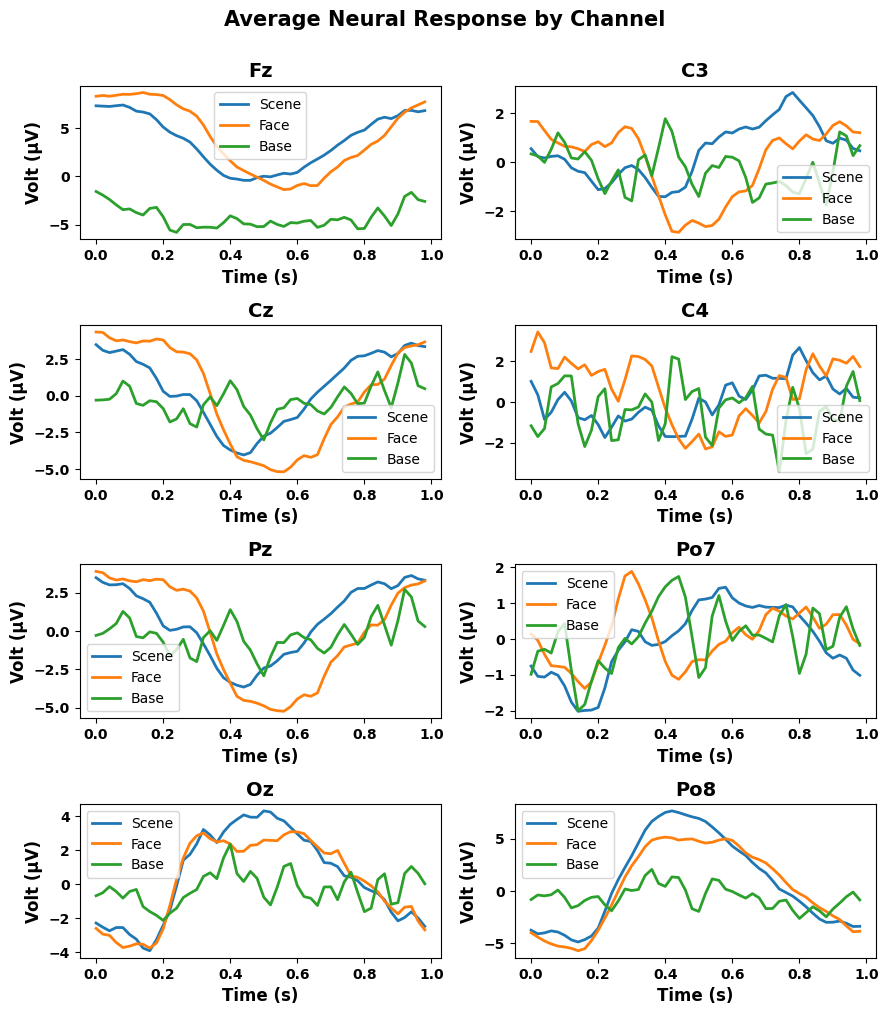

In [18]:
plt.figure(figsize=(9,12))
plt.suptitle('Average Neural Response by Channel', y=1.002, fontsize=15, weight='bold') 

for channel in range(8):
    plt.subplot(5,2, channel + 1)  
    plt.plot(time_list, squeezed_array_face[:, channel], label=f'Scene', linewidth=2)
    plt.plot(time_list, squeezed_array_scene[:, channel], label=f'Face', linewidth=2)
    plt.plot(time_list, average_array_base_squeeze[:, channel], label=f'Base', linewidth=2)
    # plt.plot(time_list, base_mean[:, channel], label=f'Base', linewidth=1)
    plt.title(selected_columns[channel], fontsize=14, weight='bold')  # Adding the channel name as the title with bold and bigger font
    
    # Bigger and bold x and y axis labels
    plt.xlabel('Time (s)', fontsize=12, weight='bold')               
    plt.ylabel('Volt (µV)', fontsize=12, weight='bold')      

    # Bigger and bold x and y axis tick labels
    plt.xticks(fontsize=10, weight='bold')
    plt.yticks(fontsize=10, weight='bold')

    plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

In [19]:
face_0_np= face_np[0].to_numpy()
face_0_np_t=np.transpose(face_0_np)
face_0_np_reshape=face_0_np_t.reshape(face_0_np_t.shape[0], 250, int(face_0_np_t.shape[1]/250))


In [20]:
face_0_np_reshape.shape

(9, 250, 41)

In [21]:
# Calculate the sampling interval
sampling_interval = 1 / 250  
times = np.arange(0, 1, step=sampling_interval)
times = times * 1000  

In [22]:
import numpy as np
import pandas as pd

def morlet_wavelet(frequency, num_cycles, sampling_rate, duration=2):
    t = np.linspace(-duration/2, duration/2, int(sampling_rate * duration), endpoint=False)
    sine_wave = np.exp(2j * np.pi * frequency * t)
    amplitude_envelope = np.exp(-t**2 * (np.pi * frequency / num_cycles)**2)
    wavelet = sine_wave * amplitude_envelope
    return wavelet

def convolve_with_wavelet(data, wavelet):
    # Ensure data is in 2D form
    if data.ndim == 1:
        data = data[np.newaxis, :]
    n_signal = data.shape[1]
    n_wavelet = len(wavelet)
    n_convolution = n_signal + n_wavelet - 1

    data_fft = np.fft.fft(data, n_convolution, axis=1)
    wavelet_fft = np.fft.fft(wavelet, n_convolution)[np.newaxis, :]
    convolution_result_fft = data_fft * wavelet_fft
    convolution_result = np.fft.ifft(convolution_result_fft, axis=1)
    # Cut the data
    start = (n_wavelet - 1) // 2
    end = start + n_signal
    return convolution_result[:, start:end]

In [23]:
f_t=np.array(np.transpose(face_np[11]))
f_t_r=f_t
f_t.shape

(9, 9250)

In [26]:
def morlet_wavelet(frequency, num_cycles, sampling_rate, duration=2):
    t = np.linspace(-duration/2, duration/2, int(sampling_rate * duration), endpoint=False)
    sine_wave = np.exp(2j * np.pi * frequency * t)
    amplitude_envelope = np.exp(-t**2 * (np.pi * frequency / num_cycles)**2)
    wavelet = sine_wave * amplitude_envelope
    return wavelet

def convolve_with_wavelet(data, wavelet):
    # Ensure data is in 2D form
    if data.ndim == 1:
        data = data[np.newaxis, :]
    n_signal = data.shape[1]
    n_wavelet = len(wavelet)
    n_convolution = n_signal + n_wavelet - 1

    data_fft = np.fft.fft(data, n_convolution, axis=1)
    wavelet_fft = np.fft.fft(wavelet, n_convolution)[np.newaxis, :]
    convolution_result_fft = data_fft * wavelet_fft
    convolution_result = np.fft.ifft(convolution_result_fft, axis=1)
    # Cut the data
    start = (n_wavelet - 1) // 2
    end = start + n_signal
    return convolution_result[:, start:end]





# Constants
frequencies = np.arange(0, 40, 2)  # 0 to 40 Hz
cycles = np.linspace(1, 10, len(frequencies))  # Variable cycles from 1 to 10
sampling_rate = 250
selected_columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']
# Assuming 'face_np' is the current class being processed
data = face_np  # Replace with 'scene_np' when processing the other class

# Initialize a dictionary to store power matrices for each channel
face_power_matrices = {channel: [] for channel in selected_columns}
scene_power_matrices = {channel: [] for channel in selected_columns}

for channel_idx, channel_name in enumerate(selected_columns):
    face_power_matrix = []
    for freq, cycle in zip(frequencies, cycles):
        face_power_blocks_base_corrected=[]
        for i in range (len(face_np)): #12
            face_i_np= face_np[i].to_numpy()
            face_i_np_t=np.transpose(face_i_np)

            # Extract one channel
            data_i_face_t = face_i_np_t[channel_idx, :]  # Trials are on the second dimension
            data_i_face_inst = face_i_np_t[8, :]
            wavelet = morlet_wavelet(freq, cycle, sampling_rate)
            convolution = convolve_with_wavelet(data_i_face_t , wavelet)    
            power = np.abs(convolution)**2

            data_i_face_inst_2d = data_i_face_inst[np.newaxis, :]
            power_with_inst=np.concatenate([power,data_i_face_inst_2d], axis=0)
            power_with_inst_t=np.transpose(power_with_inst)
            mask = (power_with_inst_t[:, 1] == 'b') | (power_with_inst_t[:, 1] == 'g')
            base_l= power_with_inst_t[mask]
            base= base_l[:, :-1]
            
            
            # Check if baseline data is present
            if base_l.size > 0:
                mean_base = np.mean(base_l[:, :-1], axis=0)
            else:
                # Skip this iteration of the loop if no baseline data is present
                continue
            
            print(base.shape)
            # mean_base= np.mean(base_l[:, :-1], axis=0) if not base_l.empty else 0
            mean_base= np.mean(base_l[:, :-1], axis=0)
            print('mean_base', mean_base)
            
            epoch_size = 250
            epochs_base = []
            for start in range(0, len(base), epoch_size):
                end = start + epoch_size
                if end <= len(base):
                    epochs_base.append(base[start:end])
                else:
                    epochs_base.append(base[start])
                epochs_base_np=np.array(epochs_base)
            print('epochs_base_np.shape', epochs_base_np.shape)
            
            # Calculate the mean across the first dimension, excluding the last column
            mean_epochs_base = np.mean(epochs_base_np, axis=0)

            first_200 = mean_epochs_base[:200]
            mean_base_200=np.mean(first_200, axis=0)
          
            
            # print('mean_base',mean_base_200)
            last_50 = mean_epochs_base[200:]
            # print('last_50', last_50)
            
            # # print('base', base.shape, base)
            activity = power_with_inst_t[~mask]
            # print('activity ', activity.shape, activity )
            
            epoch_size = 250
            epochs = []
            for start in range(0, len(activity), epoch_size):
                end = start + epoch_size
                if end <= len(activity):
                    epochs.append(activity[start:end, :-1])
                else:
                    epochs.append(activity[start:,:-1])
                epochs_np=np.array(epochs)
            print(epochs_np.shape)
            
            # Calculate the mean across the first dimension, excluding the last column
            activity_mean_epochs = np.mean(epochs_np, axis=0)
            # print('activity_mean_epochs', activity_mean_epochs.shape) #activity_mean_epochs (250, 1)
            activity_mean_epochs_concat_base=np.concatenate([last_50,activity_mean_epochs], axis=0)
            print('activity_mean_epochs_concat_base', activity_mean_epochs_concat_base.shape) #activity_mean_epochs_concat_base (300, 1)
            
            baseline_corrected_activity=activity_mean_epochs_concat_base/mean_base_200
            print('baseline_corrected_activity', baseline_corrected_activity.shape) #baseline_corrected_activity (300, 1)
            
            face_power_blocks_base_corrected.append(baseline_corrected_activity)
            # power_blocks_base_corrected_np= np.array(power_blocks_base_corrected)
            # print('power_blocks_base_corrected_np', power_blocks_base_corrected_np.shape)     
        face_power_blocks_base_corrected_np_mean=np.mean(face_power_blocks_base_corrected, axis=0)
        print('power_blocks_base_corrected_np_mean', face_power_blocks_base_corrected_np_mean.shape)
        face_power_matrices[channel_name].append(face_power_blocks_base_corrected_np_mean)
        face_power_matrix.append(face_power_blocks_base_corrected_np_mean)
        face_power_matrix_np=np.array(face_power_matrix)
        print('face_power_matrix_np', face_power_matrix_np.shape)

(1500, 1)
mean_base [2647686.2650534133]
epochs_base_np.shape (6, 250, 1)
(35, 250, 1)
activity_mean_epochs_concat_base (300, 1)
baseline_corrected_activity (300, 1)
(500, 1)
mean_base [7147166.237215531]
epochs_base_np.shape (2, 250, 1)
(34, 250, 1)
activity_mean_epochs_concat_base (300, 1)
baseline_corrected_activity (300, 1)
(750, 1)
mean_base [9605443.803185778]
epochs_base_np.shape (3, 250, 1)
(31, 250, 1)
activity_mean_epochs_concat_base (300, 1)
baseline_corrected_activity (300, 1)
(500, 1)
mean_base [5111557.326044328]
epochs_base_np.shape (2, 250, 1)
(34, 250, 1)
activity_mean_epochs_concat_base (300, 1)
baseline_corrected_activity (300, 1)
(1250, 1)
mean_base [5745383.895009676]
epochs_base_np.shape (5, 250, 1)
(36, 250, 1)
activity_mean_epochs_concat_base (300, 1)
baseline_corrected_activity (300, 1)
(1000, 1)
mean_base [2389668.7784770653]
epochs_base_np.shape (4, 250, 1)
(29, 250, 1)
activity_mean_epochs_concat_base (300, 1)
baseline_corrected_activity (300, 1)
(1000, 1)
m

In [27]:
# Constants
frequencies = np.arange(0, 40, 2)  # 0 to 40 Hz
cycles = np.linspace(1, 10, len(frequencies))  # Variable cycles from 1 to 10
sampling_rate = 250
selected_columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']
# Assuming 'face_np' is the current class being processed
data = face_np  # Replace with 'scene_np' when processing the other class

# Initialize a dictionary to store power matrices for each channel
scene_power_matrices = {channel: [] for channel in selected_columns}

for channel_idx, channel_name in enumerate(selected_columns):
    scene_power_matrix = []
    for freq, cycle in zip(frequencies, cycles):
        scene_power_blocks_base_corrected=[]
        for i in range (len(scene_np)): #12
            face_i_np= scene_np[i].to_numpy()
            face_i_np_t=np.transpose(face_i_np)

            # Extract one channel
            data_i_face_t = face_i_np_t[channel_idx, :]  # Trials are on the second dimension
            data_i_face_inst = face_i_np_t[8, :]
            wavelet = morlet_wavelet(freq, cycle, sampling_rate)
            convolution = convolve_with_wavelet(data_i_face_t , wavelet)    
            power = np.abs(convolution)**2

            data_i_face_inst_2d = data_i_face_inst[np.newaxis, :]
            power_with_inst=np.concatenate([power,data_i_face_inst_2d], axis=0)
            power_with_inst_t=np.transpose(power_with_inst)
            mask = (power_with_inst_t[:, 1] == 'b') | (power_with_inst_t[:, 1] == 'g')
            base_l= power_with_inst_t[mask]
            base= base_l[:, :-1]
            
            # Check if baseline data is present
            if base_l.size > 0:
                mean_base = np.mean(base_l[:, :-1], axis=0)
            else:
                # Skip this iteration of the loop if no baseline data is present
                continue
            
            print(base.shape)
            mean_base= np.mean(base_l[:, :-1], axis=0)
            print('mean_base', mean_base)
            
            epoch_size = 250
            epochs_base = []
            for start in range(0, len(base), epoch_size):
                end = start + epoch_size
                if end <= len(base):
                    epochs_base.append(base[start:end])
                else:
                    epochs_base.append(base[start])
                epochs_base_np=np.array(epochs_base)
            print('epochs_base_np.shape', epochs_base_np.shape)
            
            # Calculate the mean across the first dimension, excluding the last column
            mean_epochs_base = np.mean(epochs_base_np, axis=0)

            first_200 = mean_epochs_base[:200]
            mean_base_200=np.mean(first_200, axis=0)
            
            # print('mean_base',mean_base_200)
            last_50 = mean_epochs_base[200:]
            # print('last_50', last_50)
            
            # # print('base', base.shape, base)
            activity = power_with_inst_t[~mask]
            # print('activity ', activity.shape, activity )
            
            epoch_size = 250
            epochs = []
            for start in range(0, len(activity), epoch_size):
                end = start + epoch_size
                if end <= len(activity):
                    epochs.append(activity[start:end, :-1])
                else:
                    epochs.append(activity[start:,:-1])
                epochs_np=np.array(epochs)
            print(epochs_np.shape)
            
            # Calculate the mean across the first dimension, excluding the last column
            activity_mean_epochs = np.mean(epochs_np, axis=0)
            # print('activity_mean_epochs', activity_mean_epochs.shape) #activity_mean_epochs (250, 1)
            activity_mean_epochs_concat_base=np.concatenate([last_50,activity_mean_epochs], axis=0)
            print('activity_mean_epochs_concat_base', activity_mean_epochs_concat_base.shape) #activity_mean_epochs_concat_base (300, 1)
            
            baseline_corrected_activity=activity_mean_epochs_concat_base/mean_base_200
            print('baseline_corrected_activity', baseline_corrected_activity.shape) #baseline_corrected_activity (300, 1)
            
            scene_power_blocks_base_corrected.append(baseline_corrected_activity)
            # power_blocks_base_corrected_np= np.array(power_blocks_base_corrected)
            # print('power_blocks_base_corrected_np', power_blocks_base_corrected_np.shape)     
        scene_power_blocks_base_corrected_np_mean=np.mean(scene_power_blocks_base_corrected, axis=0)
        print('power_blocks_base_corrected_np_mean', scene_power_blocks_base_corrected_np_mean.shape)
        scene_power_matrices[channel_name].append(scene_power_blocks_base_corrected_np_mean)
        scene_power_matrix.append(scene_power_blocks_base_corrected_np_mean)
        scene_power_matrix_np=np.array(scene_power_matrix)
        print('scene_power_matrix_np', scene_power_matrix_np.shape)

(1250, 1)
mean_base [6640295.399639263]
epochs_base_np.shape (5, 250, 1)
(34, 250, 1)
activity_mean_epochs_concat_base (300, 1)
baseline_corrected_activity (300, 1)
(1250, 1)
mean_base [6976835.730618707]
epochs_base_np.shape (5, 250, 1)
(35, 250, 1)
activity_mean_epochs_concat_base (300, 1)
baseline_corrected_activity (300, 1)
(1000, 1)
mean_base [4225993.176087577]
epochs_base_np.shape (4, 250, 1)
(38, 250, 1)
activity_mean_epochs_concat_base (300, 1)
baseline_corrected_activity (300, 1)
(1750, 1)
mean_base [5508370.796079606]
epochs_base_np.shape (7, 250, 1)
(37, 250, 1)
activity_mean_epochs_concat_base (300, 1)
baseline_corrected_activity (300, 1)
(1250, 1)
mean_base [2769416.9257330047]
epochs_base_np.shape (5, 250, 1)
(36, 250, 1)
activity_mean_epochs_concat_base (300, 1)
baseline_corrected_activity (300, 1)
(500, 1)
mean_base [15141503.941501172]
epochs_base_np.shape (2, 250, 1)
(37, 250, 1)
activity_mean_epochs_concat_base (300, 1)
baseline_corrected_activity (300, 1)
(750, 1)


In [28]:
power_matrices['Fz'][0].shape

NameError: name 'power_matrices' is not defined

In [32]:
import numpy as np
import pandas as pd

for channel, power_data in face_power_matrices.items():
    # Convert the list of arrays into a 2D array
    power_matrix = np.concatenate(power_data, axis=1)  # Concatenate along the second axis

    # Convert to DataFrame
    df = pd.DataFrame(power_matrix)

    # Save to CSV
    df.to_csv(f'face_power_matrix_ow_{channel}.csv', index=False)




In [30]:
for channel, power_data in scene_power_matrices.items():
    # Convert the list of arrays into a 2D array
    power_matrix = np.concatenate(power_data, axis=1)  # Concatenate along the second axis

    # Convert to DataFrame
    df = pd.DataFrame(power_matrix)

    # Save to CSV
    df.to_csv(f'scene_power_matrix_ow_{channel}.csv', index=False)

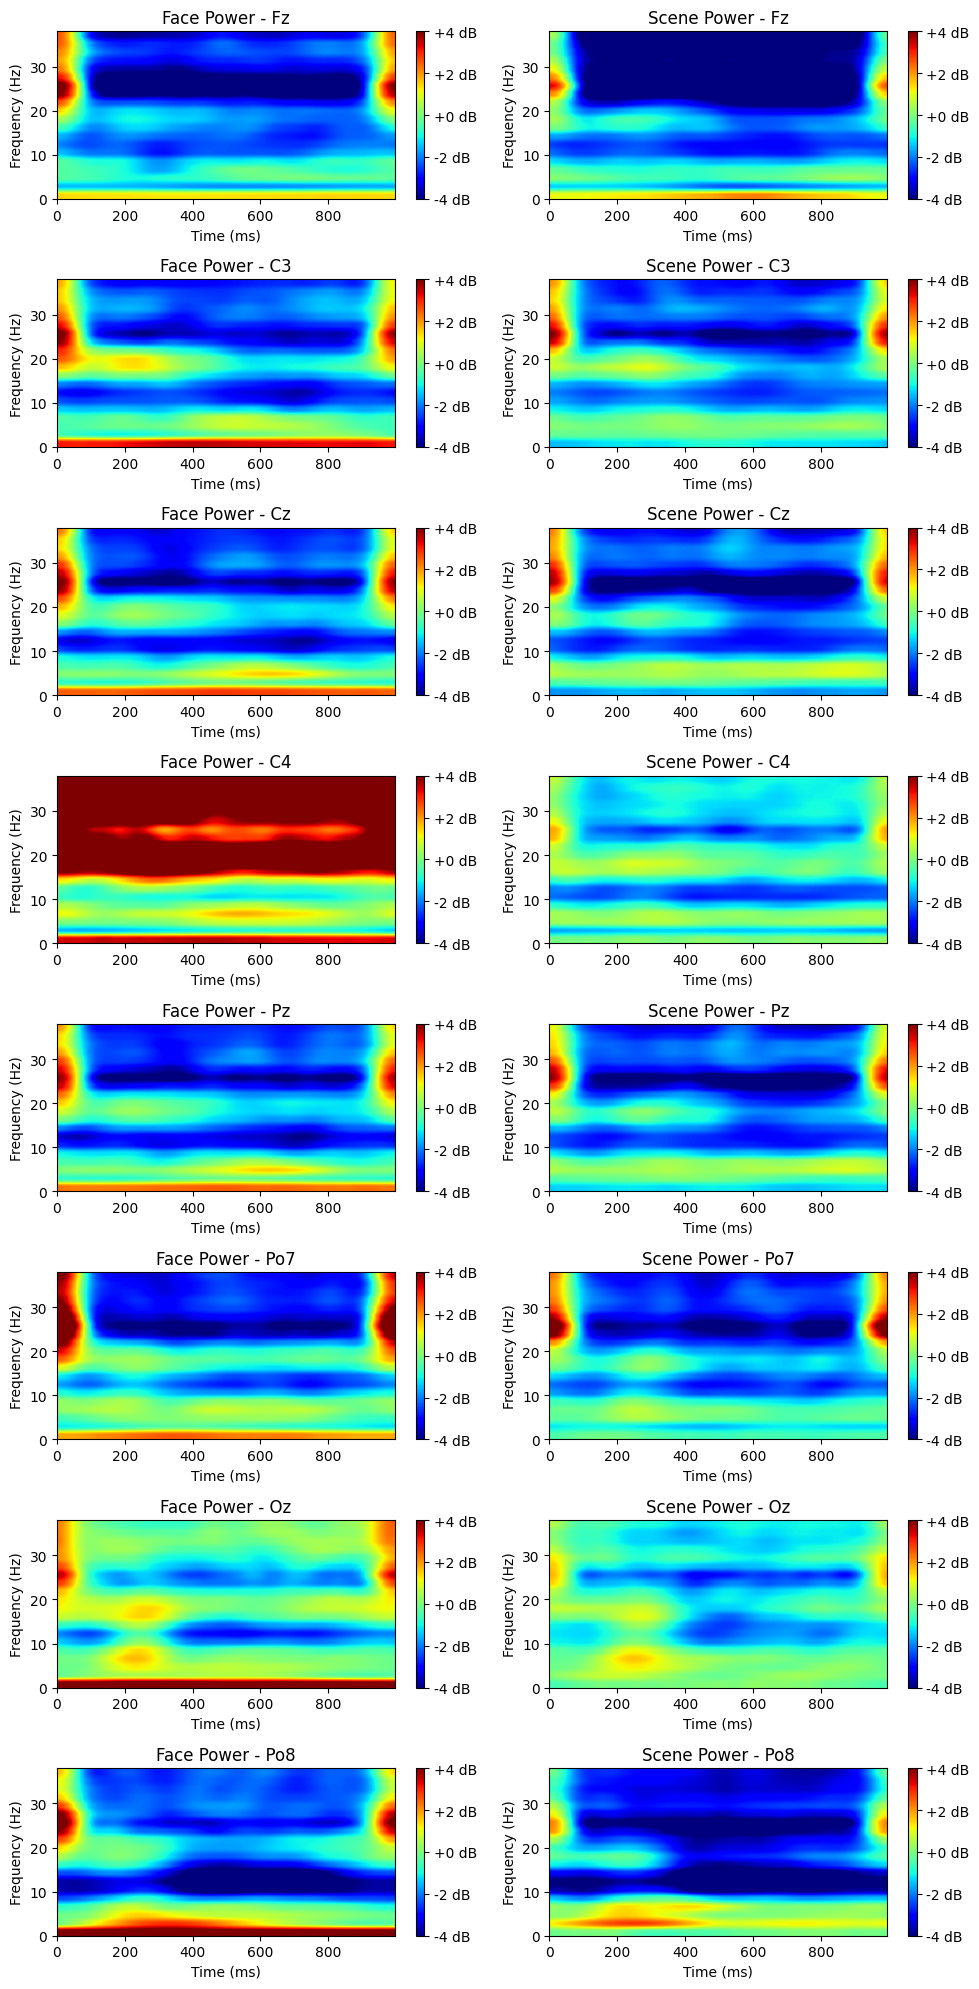

In [37]:
def plot_time_frequency(data, title, ax):
    # Use the provided axes object for plotting
    data_to_plot = 10 * np.log10(data.T + 1e-6)  # Transpose and Log transform of power; add a small constant to avoid log(0)
    img = ax.imshow(data_to_plot, aspect='auto', cmap='jet', origin='lower',
                    extent=[times[0], times[-1], frequencies[0], frequencies[-1]], vmin=-4, vmax=4)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')  # Use fig.colorbar to specify the axes
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(title)


n_channels = 8
fig, axs = plt.subplots(n_channels, 2, figsize=(10, 20))  # Adjust figsize as needed

for i, channel in enumerate(selected_columns):
    # Load from CSV
    df_face = pd.read_csv(f'face_power_matrix_ow_{channel}.csv')
    df_scene = pd.read_csv(f'scene_power_matrix_ow_{channel}.csv')

    # Convert DataFrame to numpy array
    face_power_matrix = df_face.to_numpy()
    scene_power_matrix = df_scene.to_numpy()

    # Use the data from the 50th sample point to 300th
    face_power_matrix_reduced = face_power_matrix[50:300, :]
    scene_power_matrix_reduced = scene_power_matrix[50:300, :]

    # Plot the results for face and scene
    plot_time_frequency(face_power_matrix_reduced, f'Face Power - {channel}', axs[i, 0])
    plot_time_frequency(scene_power_matrix_reduced, f'Scene Power - {channel}', axs[i, 1])

plt.tight_layout()
plt.show()



In [ ]:
# Load and plot for each channel
for channel in selected_columns:
    # Load from CSV
    df = pd.read_csv(f'scene_power_matrix_{channel}.csv')

    # Convert DataFrame to numpy array
    power_matrix = df.to_numpy()

    # Use the data from the 50th sample point to 300th
    power_matrix_reduced = power_matrix[50:300, :]

    # Plot the results
    plot_time_frequency(power_matrix_reduced, f'Power Matrix - {channel}')

In [25]:
# Constants
frequencies = np.arange(0, 40, 2)  # 0 to 40 Hz
cycles = np.linspace(1, 10, len(frequencies))  # Variable cycles from 1 to 10
sampling_rate = 250
selected_columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']

power_matrix = []
for freq, cycle in zip(frequencies, cycles):
    power_blocks_base_corrected=[]
    for i in range (len(face_np)): #12
        face_i_np= face_np[i].to_numpy()
        face_i_np_t=np.transpose(face_i_np)

        # Extract one channel
        data_i_face_t = face_i_np_t[0, :]  # Trials are on the second dimension
        data_i_face_inst = face_i_np_t[8, :]
        wavelet = morlet_wavelet(freq, cycle, sampling_rate)
        convolution = convolve_with_wavelet(data_i_face_t , wavelet)    
        power = np.abs(convolution)**2

        data_i_face_inst_2d = data_i_face_inst[np.newaxis, :]
        power_with_inst=np.concatenate([power,data_i_face_inst_2d], axis=0)
        power_with_inst_t=np.transpose(power_with_inst)
        mask = (power_with_inst_t[:, 1] == 'b') | (power_with_inst_t[:, 1] == 'g')
        base_l= power_with_inst_t[mask]
        base= base_l[:, :-1]
        print(base.shape)
        mean_base= np.mean(base_l[:, :-1], axis=0)
        print('mean_base', mean_base)
        
        epoch_size = 250
        epochs_base = []
        for start in range(0, len(base), epoch_size):
            end = start + epoch_size
            if end <= len(base):
                epochs_base.append(base[start:end])
            else:
                epochs_base.append(base[start])
            epochs_base_np=np.array(epochs_base)
        print('epochs_base_np.shape', epochs_base_np.shape)
        
        # Calculate the mean across the first dimension, excluding the last column
        mean_epochs_base = np.mean(epochs_base_np, axis=0)

        first_200 = mean_epochs_base[:200]
        mean_base_200=np.mean(first_200, axis=0)
        
        # print('mean_base',mean_base_200)
        last_50 = mean_epochs_base[200:]
        # print('last_50', last_50)
        
        # # print('base', base.shape, base)
        activity = power_with_inst_t[~mask]
        # print('activity ', activity.shape, activity )
        
        epoch_size = 250
        epochs = []
        for start in range(0, len(activity), epoch_size):
            end = start + epoch_size
            if end <= len(activity):
                epochs.append(activity[start:end, :-1])
            else:
                epochs.append(activity[start:,:-1])
            epochs_np=np.array(epochs)
        print(epochs_np.shape)
        
        # Calculate the mean across the first dimension, excluding the last column
        activity_mean_epochs = np.mean(epochs_np, axis=0)
        # print('activity_mean_epochs', activity_mean_epochs.shape) #activity_mean_epochs (250, 1)
        activity_mean_epochs_concat_base=np.concatenate([last_50,activity_mean_epochs], axis=0)
        print('activity_mean_epochs_concat_base', activity_mean_epochs_concat_base.shape) #activity_mean_epochs_concat_base (300, 1)
        
        baseline_corrected_activity=activity_mean_epochs_concat_base/mean_base_200
        print('baseline_corrected_activity', baseline_corrected_activity.shape) #baseline_corrected_activity (300, 1)
        
        power_blocks_base_corrected.append(baseline_corrected_activity)
        # power_blocks_base_corrected_np= np.array(power_blocks_base_corrected)
        # print('power_blocks_base_corrected_np', power_blocks_base_corrected_np.shape)     
    power_blocks_base_corrected_np_mean=np.mean(power_blocks_base_corrected, axis=0)
    print('power_blocks_base_corrected_np_mean', power_blocks_base_corrected_np_mean.shape)
    power_matrix.append(power_blocks_base_corrected_np_mean)
    power_matrix_np=np.array(power_matrix)
    print('power_matrix_np', power_matrix_np.shape)

(1000, 1)
mean_base [932720.6502288993]
epochs_base_np.shape (4, 250, 1)
(33, 250, 1)
activity_mean_epochs_concat_base (300, 1)
baseline_corrected_activity (300, 1)
(1500, 1)
mean_base [169258.63847681318]
epochs_base_np.shape (6, 250, 1)
(33, 250, 1)
activity_mean_epochs_concat_base (300, 1)
baseline_corrected_activity (300, 1)
(1250, 1)
mean_base [307359.8654825933]
epochs_base_np.shape (5, 250, 1)
(37, 250, 1)
activity_mean_epochs_concat_base (300, 1)
baseline_corrected_activity (300, 1)
(1750, 1)
mean_base [368898.87241917785]
epochs_base_np.shape (7, 250, 1)
(34, 250, 1)
activity_mean_epochs_concat_base (300, 1)
baseline_corrected_activity (300, 1)
(750, 1)
mean_base [1259936.4577672984]
epochs_base_np.shape (3, 250, 1)
(32, 250, 1)
activity_mean_epochs_concat_base (300, 1)
baseline_corrected_activity (300, 1)
(1250, 1)
mean_base [267268.086887326]
epochs_base_np.shape (5, 250, 1)
(32, 250, 1)
activity_mean_epochs_concat_base (300, 1)
baseline_corrected_activity (300, 1)
(1250, 1)

In [691]:
# Constants
frequencies = np.arange(0, 40, 2)  # 0 to 40 Hz
cycles = np.linspace(1, 10, len(frequencies))  # Variable cycles from 1 to 10
sampling_rate = 250

power_matrix = []
for freq, cycle in zip(frequencies, cycles):
    power_blocks_base_corrected=[]
    for i in range (len(scene_np)): #12
        face_i_np= scene_np[i].to_numpy()
        face_i_np_t=np.transpose(face_i_np)

        # Extract one channel
        data_i_face_t = face_i_np_t[7, :]  # Trials are on the second dimension
        data_i_face_inst = face_i_np_t[8, :]
        wavelet = morlet_wavelet(freq, cycle, sampling_rate)
        convolution = convolve_with_wavelet(data_i_face_t , wavelet)    
        power = np.abs(convolution)**2

        data_i_face_inst_2d = data_i_face_inst[np.newaxis, :]
        power_with_inst=np.concatenate([power,data_i_face_inst_2d], axis=0)
        power_with_inst_t=np.transpose(power_with_inst)
        mask = (power_with_inst_t[:, 1] == 'b') | (power_with_inst_t[:, 1] == 'g')
        base_l= power_with_inst_t[mask]
        base= base_l[:, :-1]
        print(base.shape)
        mean_base= np.mean(base_l[:, :-1], axis=0)
        print('mean_base', mean_base)
        
        epoch_size = 250
        epochs_base = []
        for start in range(0, len(base), epoch_size):
            end = start + epoch_size
            if end <= len(base):
                epochs_base.append(base[start:end])
            else:
                epochs_base.append(base[start])
            epochs_base_np=np.array(epochs_base)
        print('epochs_base_np.shape', epochs_base_np.shape)
        
        # Calculate the mean across the first dimension, excluding the last column
        mean_epochs_base = np.mean(epochs_base_np, axis=0)

        first_200 = mean_epochs_base[:200]
        mean_base_200=np.mean(first_200, axis=0)
        
        # print('mean_base',mean_base_200)
        last_50 = mean_epochs_base[200:]
        # print('last_50', last_50)
        
        # # print('base', base.shape, base)
        activity = power_with_inst_t[~mask]
        # print('activity ', activity.shape, activity )
        
        epoch_size = 250
        epochs = []
        for start in range(0, len(activity), epoch_size):
            end = start + epoch_size
            if end <= len(activity):
                epochs.append(activity[start:end, :-1])
            else:
                epochs.append(activity[start:,:-1])
            epochs_np=np.array(epochs)
        print(epochs_np.shape)
        # Calculate the mean across the first dimension, excluding the last column
        activity_mean_epochs = np.mean(epochs_np, axis=0)
        # print('activity_mean_epochs', activity_mean_epochs.shape) #activity_mean_epochs (250, 1)
        activity_mean_epochs_concat_base=np.concatenate([last_50,activity_mean_epochs], axis=0)
        # print('activity_mean_epochs_concat_base', activity_mean_epochs_concat_base.shape) #activity_mean_epochs_concat_base (300, 1)
        baseline_corrected_activity=activity_mean_epochs_concat_base/mean_base_200
        # print('baseline_corrected_activity', baseline_corrected_activity.shape) #baseline_corrected_activity (300, 1)
        power_blocks_base_corrected.append(baseline_corrected_activity)
        # power_blocks_base_corrected_np= np.array(power_blocks_base_corrected)
        # print('power_blocks_base_corrected_np', power_blocks_base_corrected_np.shape)     
    power_blocks_base_corrected_np_mean=np.mean(power_blocks_base_corrected, axis=0)
    print('power_blocks_base_corrected_np_mean', power_blocks_base_corrected_np_mean.shape)
    power_matrix.append(power_blocks_base_corrected_np_mean)
    power_matrix_np=np.array(power_matrix)
    print('power_matrix_np', power_matrix_np.shape)

(1500, 1)
mean_base [104262.52884559252]
epochs_base_np.shape (6, 250, 1)
(40, 250, 1)
(1500, 1)
mean_base [169112.74661285745]
epochs_base_np.shape (6, 250, 1)
(40, 250, 1)
(1500, 1)
mean_base [143743.62941678893]
epochs_base_np.shape (6, 250, 1)
(40, 250, 1)
(1500, 1)
mean_base [116310.91573832878]
epochs_base_np.shape (6, 250, 1)
(40, 250, 1)
(1500, 1)
mean_base [56175.795976103225]
epochs_base_np.shape (6, 250, 1)
(40, 250, 1)
(1500, 1)
mean_base [152807.7496278186]
epochs_base_np.shape (6, 250, 1)
(40, 250, 1)
(1500, 1)
mean_base [80541.71936775446]
epochs_base_np.shape (6, 250, 1)
(40, 250, 1)
(1500, 1)
mean_base [178944.12881709807]
epochs_base_np.shape (6, 250, 1)
(40, 250, 1)
(1500, 1)
mean_base [136127.02148818682]
epochs_base_np.shape (6, 250, 1)
(40, 250, 1)
(1500, 1)
mean_base [54944.240923371515]
epochs_base_np.shape (6, 250, 1)
(40, 250, 1)
(1250, 1)
mean_base [75814.14789927522]
epochs_base_np.shape (5, 250, 1)
(26, 250, 1)
(1250, 1)
mean_base [349729.4504362819]
epochs

In [690]:
np.savetxt("power_matrix_Face_fz.csv", power_matrix_np.reshape(20,300), delimiter=",")

In [692]:
np.savetxt("power_matrix_Scene_fz.csv", power_matrix_np.reshape(20,300),delimiter=",")

In [628]:
current_directory = os.getcwd()
print(current_directory)

c:\Users\Maryam\Documents\GitHub\Neurofeedback-Based-BCI_r\SVM for Unicorn Data


In [683]:
# Loop over each frequency
# Get the current working directory
import os
import pandas as pd


# Name of the file
file_name = 'power_matrix_Face_Pz.csv'

# Construct the full file path including the folder name
file_path = os.path.join(current_directory,  file_name)

# Load the data from the CSV file
data_df = pd.read_csv(file_path)

# Convert DataFrame to NumPy array for plotting
data_np = data_df.to_numpy()

# Slice the array to exclude the first 50 columns
data = data_np[:, 50:]


In [687]:
# Loop over each frequency
# Get the current working directory
import os
import pandas as pd


# Name of the file
file_name = 'power_matrix_Scene_Pz.csv'

# Construct the full file path including the folder name
file_path = os.path.join(current_directory, file_name)

# Load the data from the CSV file
data_df = pd.read_csv(file_path)

# Convert DataFrame to NumPy array for plotting
data_np = data_df.to_numpy()

# Slice the array to exclude the first 50 columns
data = data_np[:, 50:]


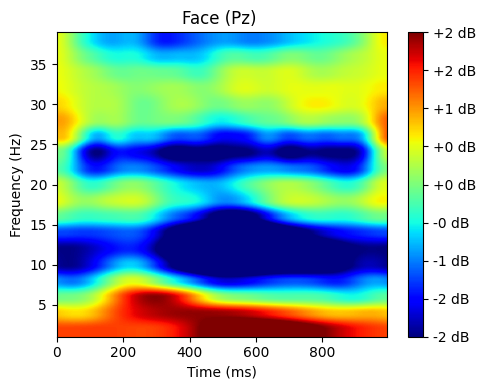

In [684]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# Define the plotting function
def plot_time_frequency(data, title):
    plt.figure(figsize=(5, 4))
    plt.imshow(10*np.log10(data), aspect='auto', cmap='jet', origin='lower',
               extent=[times[0], times[249], frequencies[0], frequencies[-1]], vmin=-2, vmax=2)  # Log transform of power; color limits as specified
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (Hz)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Constants for plotting
frequencies = np.arange(1, 40, 1)  # 0 to 40 Hz in steps of 2
sampling_rate = 250  # Sampling rate
sampling_interval = 1 / sampling_rate  # Sampling interval
times = np.arange(0, 1, step=sampling_interval) * 1000  # Convert to milliseconds


# Plot the results
plot_time_frequency(data, 'Face (Pz) ')



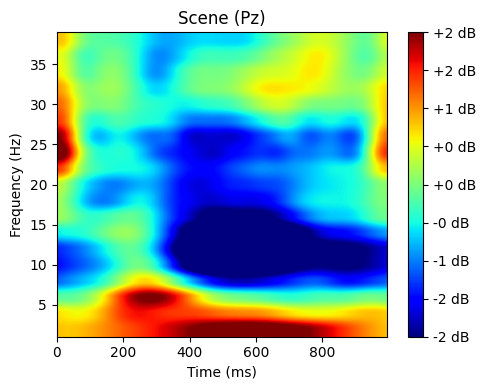

In [688]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# Define the plotting function
def plot_time_frequency(data, title):
    plt.figure(figsize=(5, 4))
    plt.imshow(10*np.log10(data), aspect='auto', cmap='jet', origin='lower',
               extent=[times[0], times[249], frequencies[0], frequencies[-1]], vmin=-2, vmax=2)  # Log transform of power; color limits as specified
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (Hz)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Constants for plotting
frequencies = np.arange(1, 40, 1)  # 0 to 40 Hz in steps of 2
sampling_rate = 250  # Sampling rate
sampling_interval = 1 / sampling_rate  # Sampling interval
times = np.arange(0, 1, step=sampling_interval) * 1000  # Convert to milliseconds


# Plot the results
plot_time_frequency(data, 'Scene (Pz)')

In [695]:
power_matrix_files = [file for file in os.listdir(current_directory) if file.startswith('power_matrix_') and file.endswith('.csv')]
len(power_matrix_files)

16

In [ ]:
import optuna
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


def objective(trial):
    # Layers and neurons
    n_layers = trial.suggest_int('n_layers', 1,3)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_layer{i}', 16,  512))
    
    # Activation function
    activation = trial.suggest_categorical('activation', ['relu', 'logistic', 'tanh', 'identity'])
    
    # Learning rate
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4,  1e-1, log=True)
    
    max_iter = trial.suggest_int('max_iter', 50, 1000)

    model = MLPClassifier(hidden_layer_sizes=tuple(layers), 
                          activation=activation, 
                          learning_rate_init=learning_rate_init,
                          max_iter=max_iter ,  # to ensure convergence in most cases
                          random_state=42)

    model.fit(X_train_mlp, y_train_mlp)

    # Evaluate
    predictions = model.predict(X_test_mlp)
    accuracy = accuracy_score(y_test_mlp, predictions)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


In [701]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np
import os

def load_and_extract_features(file_path):
    # Load the data
    data = pd.read_csv(file_path)
    
    # Calculate summary statistics for each trial (row in the CSV)
    features = data.agg(['mean', 'std', 'min', 'max', 'median']).transpose()
    
    return features

# Initialize lists to store features and labels
all_features = []
all_labels = []
current_directory = os.getcwd()
power_matrix_files = [file for file in os.listdir(current_directory) if file.startswith('power_matrix_') and file.endswith('.csv')]

# Process each file and extract features
for file_name in power_matrix_files:
    file_path = os.path.join(current_directory, file_name)
    features = load_and_extract_features(file_path)
    all_features.append(features)
    label = 1 if 'Face' in file_name else 0
    all_labels.extend([label] * len(features))

# Combine all features into a single dataframe and convert labels to a NumPy array
all_features_df = pd.concat(all_features)
all_labels = np.array(all_labels)

# Split the dataset into training+validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(all_features_df, all_labels, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier with cross-validation
cross_val_scores = cross_val_score(rf_classifier, X_train, y_train, cv=10) # 5-fold cross-validation

# Fit the model on the entire training set
rf_classifier.fit(X_train, y_train)

# Evaluate the classifier using the validation set
y_val_pred = rf_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_classification_rep = classification_report(y_val, y_val_pred)

# Output the validation accuracy and classification report
print("Validation Results:")
print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Validation Accuracy: {val_accuracy}")
print(val_classification_rep)

# Test the classifier using the test set
y_test_pred = rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_classification_rep = classification_report(y_test, y_test_pred)

# Output the test accuracy and classification report
print("\nTest Results:")
print(f"Test Accuracy: {test_accuracy}")
print(test_classification_rep)


Validation Results:
Cross-Validation Scores: [0.95486111 0.97222222 0.95486111 0.96180556 0.95486111 0.98263889
 0.94444444 0.96875    0.97222222 0.96180556]
Validation Accuracy: 0.9666666666666667
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       488
           1       0.97      0.96      0.97       472

    accuracy                           0.97       960
   macro avg       0.97      0.97      0.97       960
weighted avg       0.97      0.97      0.97       960


Test Results:
Test Accuracy: 0.98125
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       472
           1       0.98      0.98      0.98       488

    accuracy                           0.98       960
   macro avg       0.98      0.98      0.98       960
weighted avg       0.98      0.98      0.98       960



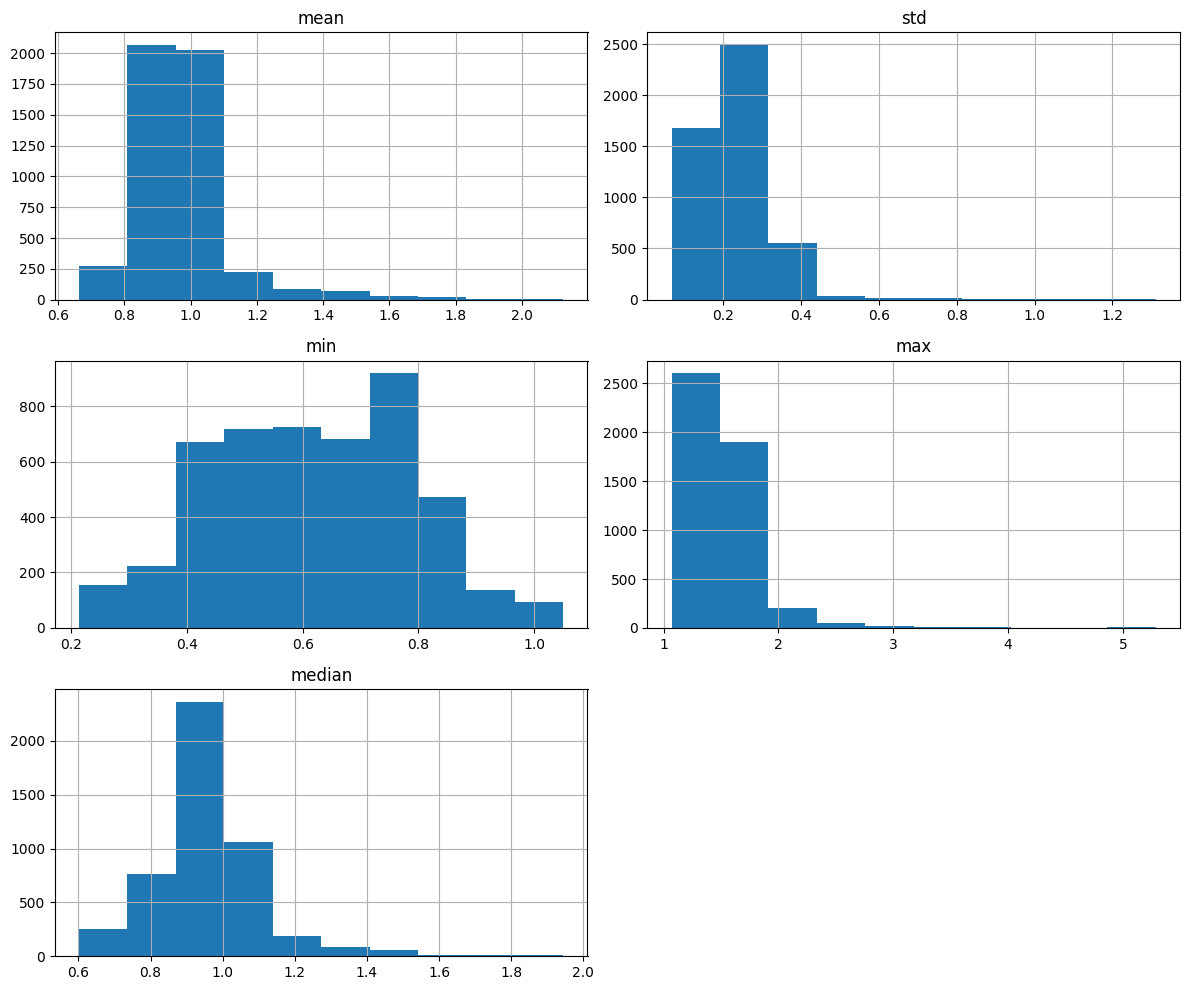

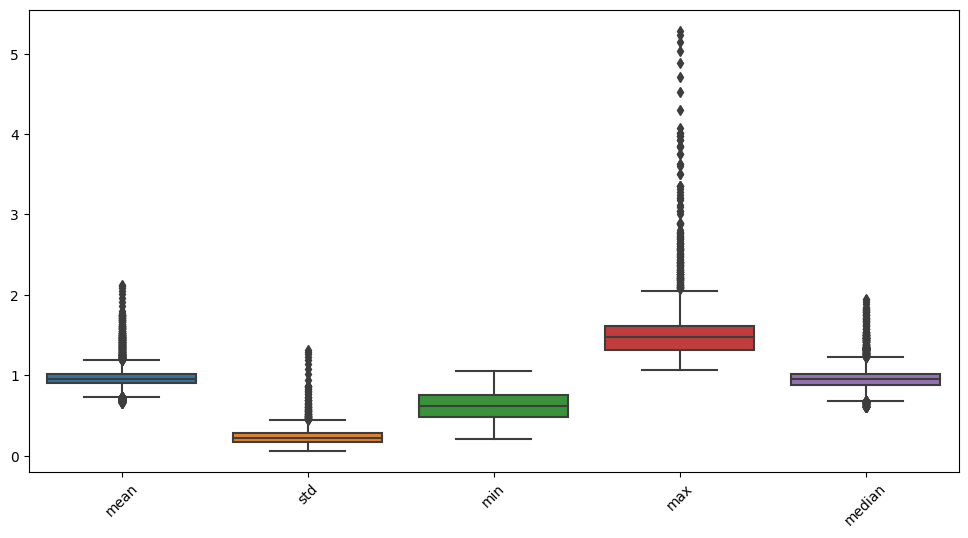

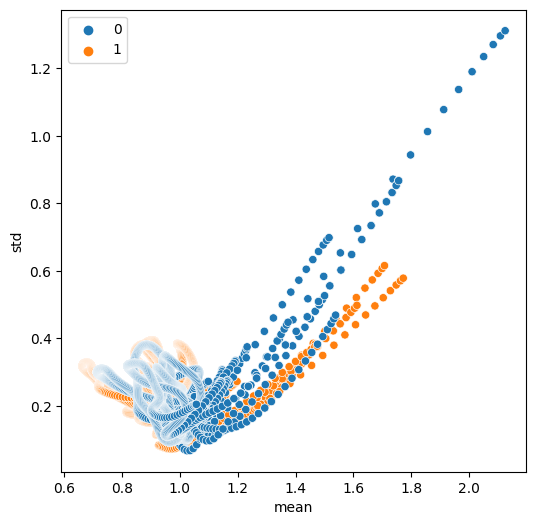

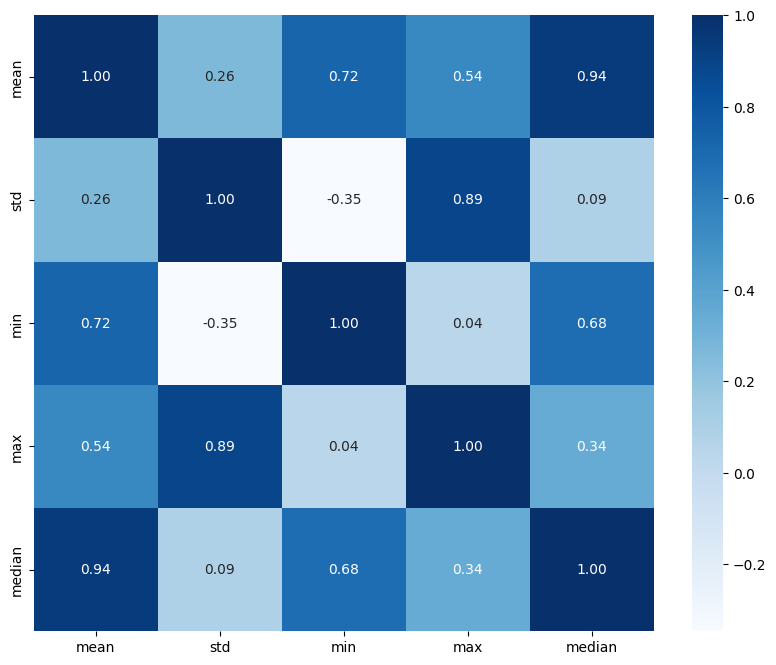

In [703]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming all_features_df is your dataframe containing all the features

# 1. Histograms
all_features_df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

# 2. Box plots
plt.figure(figsize=(12, 6))
sns.boxplot(data=all_features_df)
plt.xticks(rotation=45)
plt.show()

# 3. Scatter plots (example for 'mean' vs 'std' of a feature)
plt.figure(figsize=(6, 6))
sns.scatterplot(x='mean', y='std', data=all_features_df, hue=all_labels)
plt.show()

# 4. Pair plots (might be computationally expensive with many features)
# sns.pairplot(all_features_df, hue=all_labels)  # Uncomment to use

# 5. Heatmap of Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(all_features_df.corr(), annot=True, fmt=".2f", cmap="Blues")
plt.show()


In [1]:
import numpy as np
from scipy.optimize import minimize_scalar

# Define the MGF of the Laplace distribution for the given range of t
def mgf_laplace(t):
    return 1 / (1 - t**2) if abs(t) < 1 else np.inf

# Define the Chernoff bound function
def chernoff_bound(t, n):
    return np.exp(-t * n) * (mgf_laplace(t))**n

# Choose a large value for n, for example, n = 1000
n_large = 1000

# Perform the minimization using scipy's minimize_scalar function
# within the bounds of t where the MGF is valid
res = minimize_scalar(chernoff_bound, bounds=(-0.99, 0.99), args=(n_large,), method='bounded')

# Check the result
if res.success:
    optimal_t = res.x
    minimal_bound = res.fun
else:
    optimal_t = None
    minimal_bound = None

optimal_t, minimal_bound


(0.4142132480622706, 7.1618497535980695e-99)